In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Datasets/RIRE_patches"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 7.6 MB/s 
     |████████████████████████████████| 52.7 MB 79 kB/s 
     |████████████████████████████████| 237 kB 81.1 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 


In [3]:
import numpy as np
import torchio as tio


In [ ]:
def split_rire_data(fold):
    if fold == 1:
        ids_test = {'003', '006'} # '109', '106' 
    elif fold == 2:
        ids_test = {'007'} # '108', '105'
    elif fold == 3:
        ids_test = {'005', '009'} # '107', '102'
    total = {'003', '006', '007', '005', '009'}
    ids_train = total - ids_test
    return list(ids_train), list(ids_test)

In [ ]:
def load_images(img_dir):
  type_A = np.zeros((4*5*10, 1, 26, 256, 256))
  type_B = np.zeros((4*5*10, 1, 26, 256, 256))
  k = 0
  info = []
  for f in range(1, 4):
      _ , f_names = split_rire_data(f)
      f_names.sort()
      for i in range(1, 5):
          df = pd.read_csv(f'{img_dir}/fold{f}/patch_tlevel{i}/info_test.csv')
          info.append(df)
          for f_name in tqdm(f_names):
              tardirA = f'{img_dir}/fold{f}/patch_tlevel{i}/A/test'
              tardirB = f'{img_dir}/fold{f}/patch_tlevel{i}/B/test'
              for sample in range(10):
                  imgA = sitk.ReadImage(f'{tardirA}/patient_{f_name}_{sample}_T.mhd')
                  imgB = sitk.ReadImage(f'{tardirB}/patient_{f_name}_{sample}_T.mhd')
                  type_A[k] = sku.img_as_float(sitk.GetArrayFromImage(imgA))[None,:,:,:]
                  type_B[k] = sku.img_as_float(sitk.GetArrayFromImage(imgB))[None,:,:,:]
                  k += 1
              # imgA = sitk.ReadImage(f'{tardirA}/patient_{f_name}_R.mhd')
              # imgB = sitk.ReadImage(f'{tardirB}/patient_{f_name}_R.mhd')
              # type_A[k] = sku.img_as_float(sitk.GetArrayFromImage(imgA))[None,:,:,:]
              # type_B[k] = sku.img_as_float(sitk.GetArrayFromImage(imgB))[None,:,:,:]
              # k += 1
  y = pd.concat(info, axis=0, ignore_index=True)
  return type_A, type_B, y

In [ ]:
T1, T2, Y = load_images(data_dir)

100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


In [ ]:
len(T1)

200

In [ ]:
Y['Filename']

0      003_0
1      003_1
2      003_2
3      003_3
4      003_4
       ...  
195    009_5
196    009_6
197    009_7
198    009_8
199    009_9
Name: Filename, Length: 200, dtype: object

In [ ]:
labels = Y[['Tx', 'Ty', 'Tz', 'AngleRadX', 'AngleRadY', 'AngleRadZ']].to_numpy()
labels.shape

(200, 6)

In [ ]:
np.shape(T1)

(200, 1, 26, 256, 256)

In [ ]:
[item.shape for item in T1 if item.shape != (1,26,256,256)]

[]

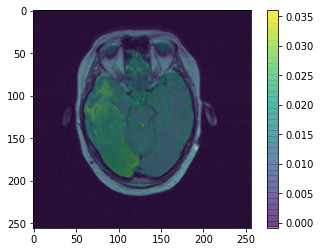

In [ ]:
plt.imshow(T1[1, 0, 5, ...], cmap='Greys_r')
plt.imshow(T2[1, 0, 5, ...], alpha = 0.5)
plt.colorbar()
plt.show()

In [ ]:
T1[1][:,:,2,0]

array([[0.00151064, 0.00141909, 0.00129702, 0.00120546, 0.00123598,
        0.00138857, 0.0016022 , 0.00175479, 0.00169375, 0.00141909,
        0.00096132, 0.00053407, 0.0002594 , 0.00022889, 0.00041199,
        0.00062562, 0.00077821, 0.00077821, 0.00065614, 0.00050355,
        0.00044251, 0.00050355, 0.00062562, 0.00077821, 0.00086976,
        0.00080873]])

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler,ConcatDataset
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


In [ ]:
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3,stride=1,padding = 'same')
        self.norm1 = nn.BatchNorm3d(32)
        self.relu1 = nn.LeakyReLU(0.1)
        self.mp1 = nn.MaxPool3d(kernel_size=2,stride=2, padding = 0)

        self.conv2 = nn.Conv3d(32, 64, kernel_size=3,stride=1,padding = 'same')
        self.norm2 = nn.BatchNorm3d(64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.mp2 = nn.MaxPool3d(kernel_size=2,stride=2, padding = 0)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3,stride=1,padding = 'same')
        self.norm3 = nn.BatchNorm3d(128)
        self.relu3 = nn.LeakyReLU(0.1)
        self.conv4 = nn.Conv3d(128,64, kernel_size=1,stride =1,padding = 'same')
        self.norm4 = nn.BatchNorm3d(64)
        self.relu4 = nn.LeakyReLU(0.1)
        self.conv5 = nn.Conv3d(64,128, kernel_size=3,stride =1,padding = 'same')
        self.norm5 = nn.BatchNorm3d(128)
        self.relu5 = nn.LeakyReLU(0.1)
        self.mp3 = nn.MaxPool3d(kernel_size=2,stride=2, padding = 0)

        self.conv6 = nn.Conv3d(128, 256, kernel_size=3,stride=1,padding = 'same')
        self.norm6 = nn.BatchNorm3d(256)
        self.relu6 = nn.LeakyReLU(0.1)
        self.conv7 = nn.Conv3d(256,128, kernel_size=1,stride =1,padding = 'same')
        self.norm7 = nn.BatchNorm3d(128)
        self.relu7 = nn.LeakyReLU(0.1)
        self.conv8 = nn.Conv3d(128,256, kernel_size=3,stride =1,padding = 'same')
        self.norm8 = nn.BatchNorm3d(256)
        self.relu8 = nn.LeakyReLU(0.1)
        self.mp4 = nn.MaxPool3d(kernel_size=2,stride=2, padding = 0)

        self.conv9 = nn.Conv3d(256, 512, kernel_size=3,stride=1,padding = 'same')
        self.norm9 = nn.BatchNorm3d(512)
        self.relu9 = nn.LeakyReLU(0.1)
        self.conv10 = nn.Conv3d(512,256, kernel_size=1,stride =1,padding = 'same')
        self.norm10 = nn.BatchNorm3d(256)
        self.relu10 = nn.LeakyReLU(0.1)
        self.conv11 = nn.Conv3d(256,512, kernel_size=3,stride =1,padding = 'same')
        self.norm11 = nn.BatchNorm3d(512)
        self.relu11 = nn.LeakyReLU(0.1)
        self.conv12 = nn.Conv3d(512,256, kernel_size=1,stride =1,padding = 'same')
        self.norm12 = nn.BatchNorm3d(256)
        self.relu12 = nn.LeakyReLU(0.1)
        self.conv13 = nn.Conv3d(256,512, kernel_size=3,stride =1,padding = 'same')
        self.norm13 = nn.BatchNorm3d(512)
        self.relu13 = nn.LeakyReLU(0.1)
        self.mp5 = nn.MaxPool3d(kernel_size=(1,2,2),stride=(1,2,2), padding = 0)

        self.conv14 = nn.Conv3d(512, 1024, kernel_size=3,stride=1,padding = 'same')
        self.norm14 = nn.BatchNorm3d(1024)
        self.relu14 = nn.LeakyReLU(0.1)
        self.conv15 = nn.Conv3d(1024,512, kernel_size=1,stride =1,padding = 'same')
        self.norm15 = nn.BatchNorm3d(512)
        self.relu15 = nn.LeakyReLU(0.1)
        self.conv16 = nn.Conv3d(512,1024, kernel_size=3,stride =1,padding = 'same')
        self.norm16 = nn.BatchNorm3d(1024)
        self.relu16 = nn.LeakyReLU(0.1)
        self.conv17 = nn.Conv3d(1024,512, kernel_size=1,stride =1,padding = 'same')
        self.norm17 = nn.BatchNorm3d(512)
        self.relu17 = nn.LeakyReLU(0.1)
        self.conv18 = nn.Conv3d(512,1024, kernel_size=3,stride =1,padding = 'same')
        self.norm18 = nn.BatchNorm3d(1024)
        self.relu18 = nn.LeakyReLU(0.1)

        self.conv19 = nn.Conv3d(1024,2, kernel_size=1,stride =1,padding = 'same')
        self.flat = nn.Flatten()

        # self.fc1= nn.Linear(1024, 600)
        # self.fc2 = nn.Linear(600,1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.mp1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.mp2(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.norm5(x)
        x = self.relu5(x)
        x = self.mp3(x)

        x = self.conv6(x)
        x = self.norm6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.norm7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.norm8(x)
        x = self.relu8(x)
        x = self.mp4(x)

        x = self.conv9(x)
        x = self.norm9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.norm10(x)
        x = self.relu10(x)
        x = self.conv11(x)
        x = self.norm11(x)
        x = self.relu11(x)
        x = self.conv12(x)
        x = self.norm12(x)
        x = self.relu12(x)
        x = self.conv13(x)
        x = self.norm13(x)
        x = self.relu13(x)
        x = self.mp5(x)
 
        x = self.conv14(x)
        x = self.norm14(x)
        x = self.relu14(x)
        x = self.conv15(x)
        x = self.norm15(x)
        x = self.relu15(x)
        x = self.conv16(x)
        x = self.norm16(x)
        x = self.relu16(x)
        x = self.conv17(x)
        x = self.norm17(x)
        x = self.relu17(x)
        x = self.conv18(x)
        x = self.norm18(x)
        x = self.relu18(x)

        x = self.conv19(x)
        x = self.flat(x)

        return x 

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

modelT1 = DCNN()
modelT1.to(device)

DCNN(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.1)
  (mp1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (norm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (mp2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (norm3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.1)
  (conv4): Conv3d(128, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
  (norm4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): Le

In [ ]:
from torchsummary import summary

print(summary(modelT1, np.shape(T1[1])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 26, 256, 256]             896
       BatchNorm3d-2     [-1, 32, 26, 256, 256]              64
         LeakyReLU-3     [-1, 32, 26, 256, 256]               0
         MaxPool3d-4     [-1, 32, 13, 128, 128]               0
            Conv3d-5     [-1, 64, 13, 128, 128]          55,360
       BatchNorm3d-6     [-1, 64, 13, 128, 128]             128
         LeakyReLU-7     [-1, 64, 13, 128, 128]               0
         MaxPool3d-8        [-1, 64, 6, 64, 64]               0
            Conv3d-9       [-1, 128, 6, 64, 64]         221,312
      BatchNorm3d-10       [-1, 128, 6, 64, 64]             256
        LeakyReLU-11       [-1, 128, 6, 64, 64]               0
           Conv3d-12        [-1, 64, 6, 64, 64]           8,256
      BatchNorm3d-13        [-1, 64, 6, 64, 64]             128
        LeakyReLU-14        [-1, 64, 6,

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1= nn.Linear(256, 10)
        self.tanh = nn.Tanh()
        self.dp1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(10,6)
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.dp1(x)
        x = self.fc2(x)
        return x

In [ ]:
linear_model = ANN()
linear_model.to(device)

ANN(
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (tanh): Tanh()
  (dp1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=10, out_features=6, bias=True)
)

In [ ]:
from sklearn.model_selection import train_test_split
trainx1, testx1, trainlabel1, testlabel1 = train_test_split(T1, labels, test_size=0.30, random_state=20)
trainx2, testx2, trainlabel2, testlabel2 = train_test_split(T2, labels, test_size=0.30, random_state=20)


In [ ]:
img_train1 = torch.from_numpy(trainx1)
img_test1 = torch.from_numpy(testx1)
lab_train1= torch.from_numpy(trainlabel1)
lab_test1 = torch.from_numpy(testlabel1)

img_train2 = torch.from_numpy(trainx2)
img_test2 = torch.from_numpy(testx2)
lab_train2= torch.from_numpy(trainlabel2)
lab_test2 = torch.from_numpy(testlabel2)

In [ ]:
num_epochs = 30
batch_size = 20
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.1, momentum=0.9)

In [ ]:
import torch.utils.data as data_utils
train_tensor = data_utils.TensorDataset(img_train1, lab_train1, img_train2, lab_train2) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True,num_workers=2)

test_tensor = data_utils.TensorDataset(img_test1, lab_test1, img_test2, lab_test2) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

In [ ]:
# for epoch in range(num_epochs):
#     modelT1.train()
#     modelT2.train()
#     linear_model.train()
#     for i, (images1, labels1, images2, labels2) in enumerate(train_loader1):
#         optimizer.zero_grad()
        
#         # Run the forward pass
#         images1=images1.to(device)
#         labels1=labels1.to(device)
#         outputs1 = modelT1(images1)
        
#         images2=images1.to(device)
#         labels2=labels1.to(device)
#         outputs2 = modelT2(images2)
#         images = torch.cat(outputs1,outputs2)
#         outputs = linear_model(images)
#         labels = torch.cat(labels1, labels2)

#         loss = criterion(outputs, labels)
#         loss_list.append(loss.item())

#         # Backprop and perform Adam optimisation
        
#         loss.backward()
#         optimizer.step()
#         # Track the accuracy
#         total = len(labels)
#         predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
# #         print(predicted)
# #         print(labels)
#         correct = (predicted == labels.long()).sum().item()
#         train_accuracy = 100 * (correct / float(total))
#         train_acc_list.append(train_accuracy)


#         # count += 1
#         if count % 50 == 0:
#             model.eval()
#             # Calculate Accuracy         
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for (images1, labels1, images2, labels2) in test_loader:
#                 signals=signals.to(device)
#                 labels=labels.float().to(device)
#                 # Forward propagation
#                 outputs = model(signals.float())
                
#                 # Get predictions from the maximum value
#                 predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
                
#                 # Total number of labels
#                 total += len(labels)
                
#                 correct += (predicted == labels).sum().item()
            
#             test_accuracy = 100 * correct / float(total)
            
#             # store loss and iteration
#             loss_list.append(loss.item())
#             test_acc_list.append(test_accuracy)
            
#         if (epoch+1) % 5 == 0 or epoch==0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
#                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
#                           train_accuracy, test_accuracy))